# Building a realtime anomaly detector

###  By: Peter Tillotson 
[( Acumed Consulting Ltd )](https://acumedconsulting.com)

<br>

| Part | Learning Objectives |
| ---- | :----------------- |
| 1 | Setting up your dev environment and getting some data to work with |
| 2 | Learning to read and process data |
| 3 | Simple linear regression, building stats based detectors | 
| 4 | Understanding seasonality |


At the end of the season you should have built a realtime detector.

## About me

 - Lead data analyst at Riot Games
 - Passionate about Gaming Analytics
 - Set up and run the London Gaming Analytics Meetup
 - Have done a bunch of Security work too
 - Learning to play drums
 - PhD Distributed intelligent agents
 - 20yrs experience R&D making things fast


<div style='width: 100%;'>
<img style='float: left;' src='../static/business_card.png' width='50%'/> 
<img style='float: right; vertical-align: bottom' src='../static/PETER_TILOTSON__40_small.png' width='50%'/>
</div>

# Part 1

> Development environment setup

tl;dr:
 - Create a virtual environment for our project
 - Install all the project dependencies
 - Pull down and extract some data to play with

## A note on Python versions

**Always Python 3+** These days I would recommend Python 3.6 and above. 

Python 2.7 persists because its used in quite a few Linux distros to manage 
packages, OS scripts etc. 

If you can use Python 3 do so, occasionally there is a package that does not 
support Python 3, it is rare these day and may be because its not maintained 
or there alternatives that have superceded in 3.

> tl;dr we need to let go of 2.7

### Virtual Environments

Are clean Python virtual install, they are actually symlinks to your 
main Python install, but they don't have any installed packages. This 
means when working on lots of projects fewer dependency conflicts. 

```bash
base> pip install virtualenv
base> virtualenv -p python3 venv      
base> source venv/bin/activate
venv> pip install -r requirements.txt
```

On Windows I would advise the Anaconda install of Python generally, some 
things are easier with this install. It has a built in version to.

https://towardsdatascience.com/getting-started-with-python-environments-using-conda-32e9f2779307

I prefer virtualenv, as I work on Mac, Linux and Windows.  

On Windows the activate is `.\venv\Scripts\activate.bat`

### Project Dependencies

The convention is for Python projects to have a `requirements.txt` in 
there base directory, often alongside a `distutils` `setup.py` file. 
You can specify packages your project depend on in this file, or 
you can.

```
venv> pip install pandas jupyter scipy
venv> pip freeze > requirements.txt
```

Which creates the requirements file from currently installed packages. 

These can be installed with

```
venv> pip install -r requirements.txt
```

Follow this link to download my requirements.txt file. 

### **Excercise 1a** 

Todo:
 - Create a new project directory, change into it
 - Get your virtualenv created pointing to a Python3 install
 - Switch into your new virtual environment 
 - Download and install the requirements in you virtual env
 
### **Excercise 1b**

Todo:
 - Create two folders in your project `data` and `notebooks`
 - Get data: https://github.com/numenta/NAB/archive/v1.0.zip
   - If you raced through the last bit get data programmatically
   - Else download manually and unpack into data

In [1]:
import requests, zipfile, io, os, glob, shutil

from os.path import exists, join, split

prefix = 'NAB-1.0/data'
data_dir = '../data'
fd_done = 'success.txt'

if exists( join(data_dir, fd_done) ) == False:
    if exists(data_dir) == False:
        os.mkdir(data_dir)

    url = 'https://github.com/numenta/NAB/archive/v1.0.zip'
    r = requests.get(url)

    with zipfile.ZipFile(io.BytesIO(r.content)) as z:
        for n in z.namelist():
            if n.startswith(prefix) and n.endswith('csv'):
                z.extract(n, path=data_dir)

    path = join(data_dir, prefix, '*')
    for n in glob.glob(path):
        head, tail = split(n)
        new_path = join(data_dir, tail)
        shutil.move(n, new_path)
    head, tail = split(join(data_dir, prefix))
    shutil.rmtree(head)
    with open(join(data_dir, fd_done), 'w') as fd:
        fd.write('done')
else:
    print('data already pulled')

data already pulled


We did it 

<img src='../static/200w_d.gif' width='400'/>

# Part 2

> Read and process data

tl;dr:
 - Read data with Python Pandas
 - Simple plot with Matplotlib and Plotly
 - Interpolate and 
 - Resample

In [2]:
import pandas as pd

# timestamp,value
# 2015-02-26 21:42:53,35
# 2015-02-26 21:47:53,41
# 2015-02-26 21:52:53,32
# 2015-02-26 21:57:53,36
# 2015-02-26 22:02:53,32

df = pd.read_csv('../data/realTweets/Twitter_volume_GOOG.csv', 
    index_col=0, 
    parse_dates=True
)
df.head(5)

value
timestamp                 
2015-02-26 21:42:53     35
2015-02-26 21:47:53     41
2015-02-26 21:52:53     32
2015-02-26 21:57:53     36
2015-02-26 22:02:53     32

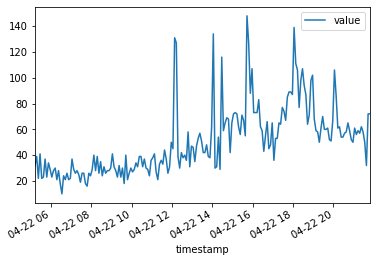

In [3]:
import matplotlib
%matplotlib inline

df.tail(200).plot()

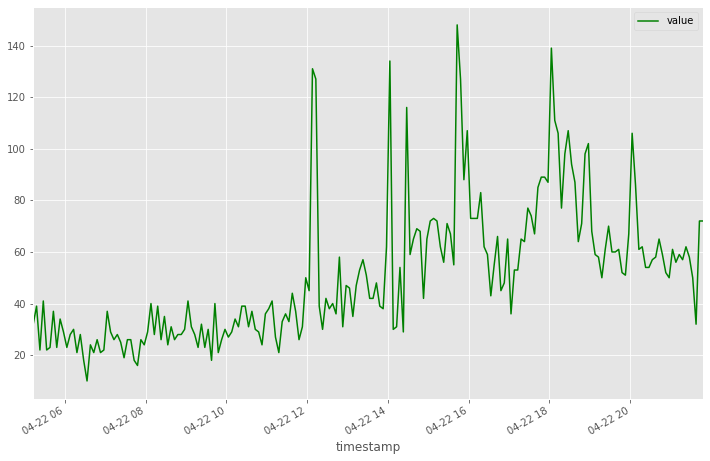

In [4]:
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
matplotlib.style.use('ggplot')
df.tail(200).plot(color='g')

In [5]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(
        x=df.tail(200).index, 
        y=df.tail(200).value,
        mode='lines'
))
fig.show(config={'displaylogo':False})

### Handling dirty data

> Data science is 50% ETL

The data is never quite right, and we have to accept that. In the next few
slides we will look at handling two common problems. 

#### Resampling

Used to get data onto a common interval between samples

#### Interpolation

Sometimes needed when you have holes in your data, these can be caused by 
resampling or just inherent in the data.


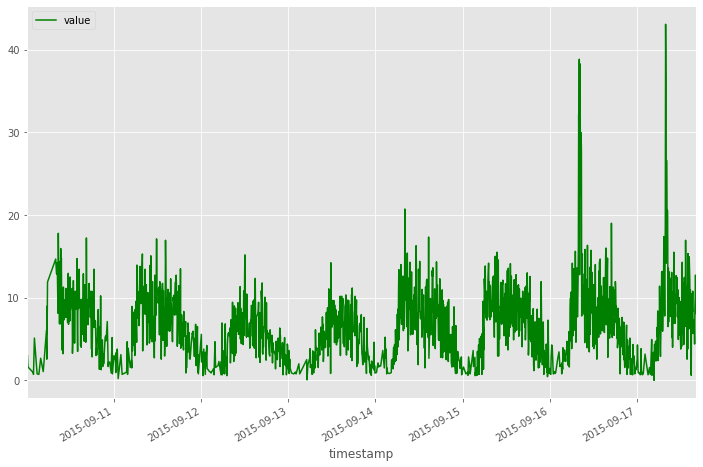

In [6]:
fd = '../data/realTraffic/occupancy_t4013.csv'
df = df = pd.read_csv(fd, 
    index_col=0, 
    parse_dates=True
)
#df = df['2015-04-10':]
df = df['2015-09-10':]
df.plot(color='g')

In [7]:
df.head(10).reset_index().transpose()

0                    1                    2  \
timestamp  2015-09-10 00:03:00  2015-09-10 00:13:00  2015-09-10 00:18:00   
value                     2.61                 3.06                 2.11   

                             3                    4                    5  \
timestamp  2015-09-10 00:23:00  2015-09-10 01:48:00  2015-09-10 01:53:00   
value                     1.61                 0.94                 0.72   

                             6                    7                    8  \
timestamp  2015-09-10 02:08:00  2015-09-10 02:53:00  2015-09-10 03:22:00   
value                     5.11                 0.78                 0.72   

                             9  
timestamp  2015-09-10 03:52:00  
value                     2.67

In [8]:
df.head(10).reset_index().diff().transpose()

0                1                2                3  \
timestamp NaT  0 days 00:10:00  0 days 00:05:00  0 days 00:05:00   
value     NaT             0.45            -0.95             -0.5   

                         4                5                6                7  \
timestamp  0 days 01:25:00  0 days 00:05:00  0 days 00:15:00  0 days 00:45:00   
value                -0.67            -0.22             4.39            -4.33   

                         8                9  
timestamp  0 days 00:29:00  0 days 00:30:00  
value                -0.06             1.95

Commands:
 - **head** : take the first n rows
 - **reset_index**: without options turns the index into a column (needed here for diff to work)
 - **diff**: Difference, from one row to the next
 - **transpose**: Turn each column into a row
 
**Note**: The difference between original dataframe sampling time is
all over the place. In your application it is up to your judgement as to
whether this matters. 

In this case to fix it I would resample at perhaps 15 or 30mins.

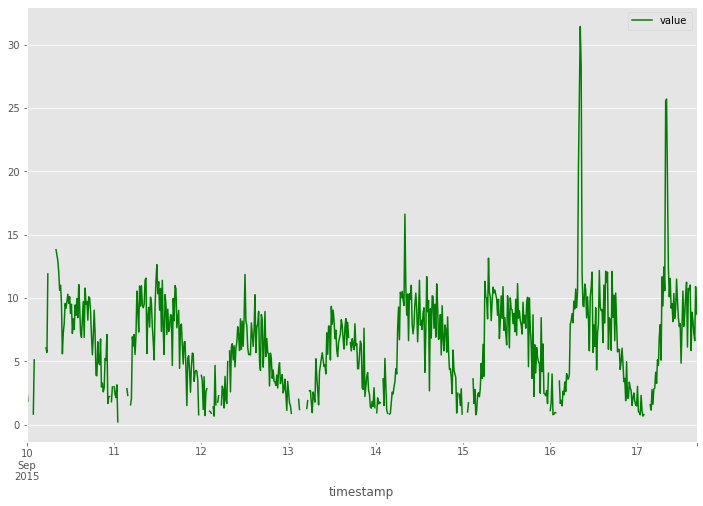

In [9]:
s_rule = '15T' # 15 mins
sf = df.resample(s_rule).mean() # You need to choose how to aggregate
sf.plot(color='g')

Oops, we now have holes in the data

In [10]:
sf.head(10).reset_index().transpose()

0                    1                   2  \
timestamp  2015-09-10 00:00:00  2015-09-10 00:15:00 2015-09-10 00:30:00   
value                    2.835                 1.86                 NaT   

                            3                   4                   5  \
timestamp 2015-09-10 00:45:00 2015-09-10 01:00:00 2015-09-10 01:15:00   
value                     NaT                 NaT                 NaT   

                            6                    7                    8  \
timestamp 2015-09-10 01:30:00  2015-09-10 01:45:00  2015-09-10 02:00:00   
value                     NaT                 0.83                 5.11   

                            9  
timestamp 2015-09-10 02:15:00  
value                     NaT

We can fill the holes with interpolation. There are lots of 
methods including `quadratic`, `polynomial`.

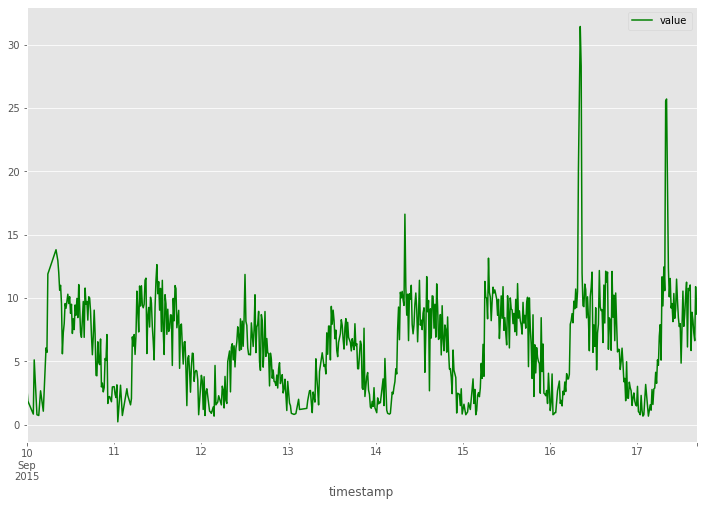

In [11]:
sf.interpolate(method='time',inplace=True)
sf.plot(color='g')

In [12]:
sf.head(10).reset_index().transpose()

0                    1                    2  \
timestamp  2015-09-10 00:00:00  2015-09-10 00:15:00  2015-09-10 00:30:00   
value                    2.835                 1.86              1.68833   

                             3                    4                    5  \
timestamp  2015-09-10 00:45:00  2015-09-10 01:00:00  2015-09-10 01:15:00   
value                  1.51667                1.345              1.17333   

                             6                    7                    8  \
timestamp  2015-09-10 01:30:00  2015-09-10 01:45:00  2015-09-10 02:00:00   
value                  1.00167                 0.83                 5.11   

                             9  
timestamp  2015-09-10 02:15:00  
value                  3.66667

### **Excercise 2:** Your turn

Todo:
 - Read file using pandas `../data/realTraffic/occupancy_t4013.csv`
 - Resample hourly, assuming the value is number of items purchased
 - Do you need to interpolate?
 - Plot the raw and resampled data

We did it again
<img src='../static/dog_pool.gif' width='400'/>


# Part 3

> Linear Regression, simple detectors

tl;dr:
 - Basic understanding of regression
 - Seen quadratic and polynomial regression
 - Understand mean, standard deviation with relation to a normal distribution
 - Used this knowledge to build a simple anomaly detector


The simplest case of linear regression attempts to plot a straight line of best fit through the data.

The equation for a straight line is:  
>    $ y = m \times x + c $

Where:  
> $x$ - value on the horizontal axis   
> $y$ - value in on the verticle axis   
> $m$ - is the gradient, and   
> $c$ - is the crossover ( $y$ value when $x=0$ )    

[[ Duke ]](http://people.duke.edu/~rnau/411diff.htm) - Statistical stationarity: A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. 

In this case the statistical properties of the future are the same as those of the past. When using linear regression with arbitrary time series we need to take great care. It turns out that most real life time series are none stationary. 

With that caveat, the following builds a simple model and uses data derived statistics to determine unusual behaviour.    

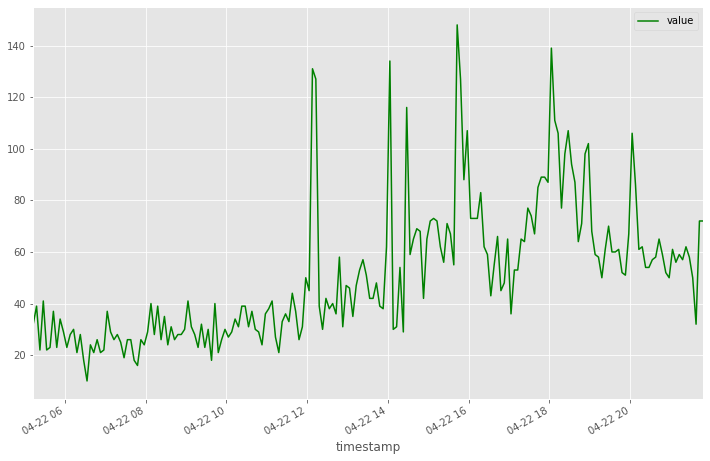

In [13]:
import scipy as sp
import numpy as np

import matplotlib.pyplot as plt

df = pd.read_csv('../data/realTweets/Twitter_volume_GOOG.csv', 
    index_col=0, 
    parse_dates=True
)
df = df.tail(200)
df.plot(color='g')

The following uses **SciPy**'s `polyfit` function to calculate the gradient ($m$) and crossover($c$). Then using the 'polyval' function with our calculated $m$ and $c$ for each time index, the $y$ values of the line of best fit are found. 

For the purpose of anomaly detection, if we make a further assumption that the underlying statistics follow an normal distribution then for: 
> $Pr( \mu - \sigma \leq x \leq \mu + \sigma ) \approx 0.6827$   
> $Pr( \mu - 2\sigma \leq x \leq \mu + 2\sigma ) \approx 0.9545$   
> $Pr( \mu - 3\sigma \leq x \leq \mu + 3\sigma ) \approx 0.9973$   

where:
> $\mu$ - mean   
> $\sigma$ - standard deviation   

So: 
> $\approx32\%$ of the data falls outside the bands 1 standard deviation away from the mean.   
> $\approx5\%$ of the data falls outside the bands 2 standard deviation away from the mean.   
> $\approx0.27\%$ of the data falls outside the bands 3 standard deviation away from the mean.   

This is illustrated below by shading the band 2 standard deviations from the mean.

## A note on time series $x$ values

The data set here uses textual dates for it's $x$ value (index).

In [14]:
df.head(5) #show the first 5 records

value
timestamp                 
2015-04-22 05:12:53     32
2015-04-22 05:17:53     39
2015-04-22 05:22:53     22
2015-04-22 05:27:53     41
2015-04-22 05:32:53     22

 - The functions used below cannot operate on either text or date values, 
 - So convert text to dates then dates to unix time (milliseconds since epoch) 
 - This can be represented as an 'int'. 
 
These days there are Scikit learn regression models that play better with Pandas 
time index dataframes. 

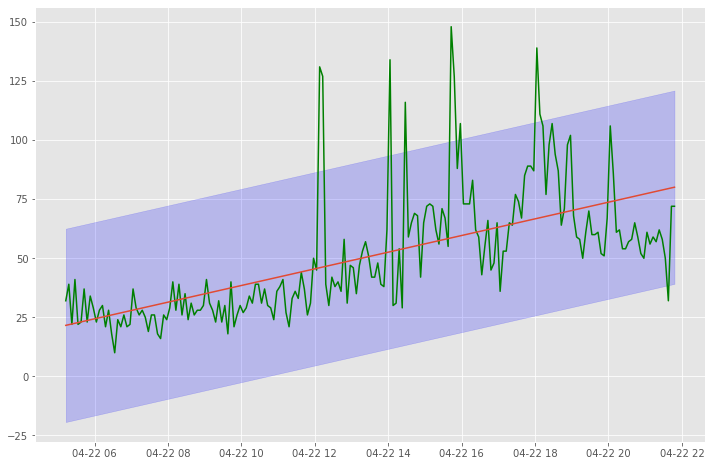

In [15]:
# Have to convert the dates to numeric for the calc
t_idx = pd.to_numeric(df.index)

y = df['value']

# y_fit = m*x+c
(m, c) = sp.polyfit(t_idx, y, 1)
y_fit = sp.polyval([m,c],t_idx)

std = np.std(y-y_fit)

# we can now plot with original index
t_idx = df.index
plt.plot(t_idx, y, color='g')
plt.plot(t_idx, y_fit)
plt.fill_between(t_idx, y_fit-2*std, y_fit+2*std, color='b', alpha=0.2)

It is a trivial exercise to identify any value that does not sit within the shaded blue area.

## Curve fitting with higher order polynomial

A straight line is this simplest case, the same approach can use higher order quadratics, for example:

>  $y = a \times x^2 + b \times x + c$



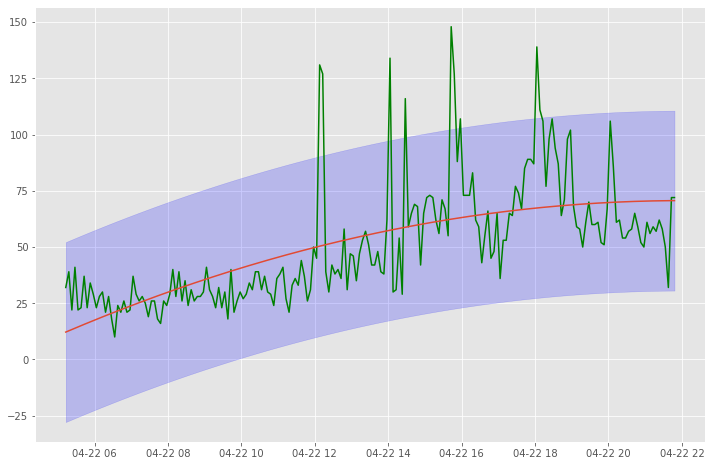

In [16]:
t_idx = pd.to_numeric(df.index)
(a, b, c) = sp.polyfit(t_idx, y, 2)
y_fit = sp.polyval([a,b,c],t_idx)

std = np.std(y-y_fit)

# we can now plot with original index
t_idx = df.index
plt.plot(t_idx, y, color='g')
plt.plot(t_idx, y_fit)
plt.fill_between(t_idx, y_fit-2*std, y_fit+2*std, color='b', alpha=0.2)

# Using a Rolling Mean and Standard Deviation for Anomaly Detection

Perhaps a better approach is to just look at the rolling mean and standard deviation over a short historic window. As you can see, because mean and standard deviation are functions of recent history, they follow the trends more closely. This approach is not as susceptable to the problems relating to non stationary data but note how the standard deviation bands get wider when the raw signal is more variable. 

> In Rolling Mean approaches, the mean lags the signal by the length of the window and   
> recent signal volatility takes time to dissipate. 

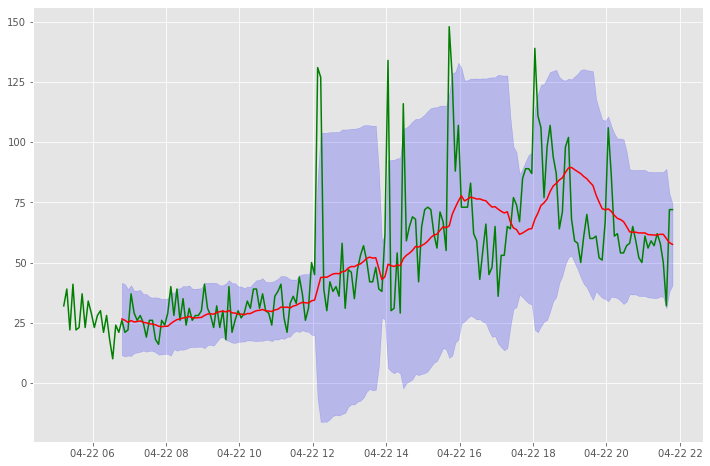

In [17]:
# rolling window of last n samples
r_win = 20
v_mean = df['value'].rolling(r_win).mean()
v_std = df['value'].rolling(r_win).std()

plt.figure()
plt.plot(df.index, df['value'], color='g')
plt.plot(df.index, v_mean, color='r')
plt.fill_between(df.index, v_mean-2*v_std, v_mean+2*v_std, color='b', alpha=0.2)

### **Excercise 3:** Your turn

Todo:
 - Turn this knowledge into an anomaly detector

```python
class Detector:
    
    def __init__(self):
        self.history = []
        
    def detect(self, tpl):
        self.history.append(tpl)
        tf = pd.DataFrame(self.history)
        # Your code goes here
        print(tf)
        return tpl

obj = Detector()

df.reset_index().apply(obj.detect, axis=1)
```
 - If you get time plot results  

In [18]:
class Detector:
    
    def __init__(self):
        self.history = []
        
    def detect(self, tpl): # receives a row at a time
        self.history.append(tpl) # keeps track of all in history
        tf = pd.DataFrame(self.history)
        # Your code goes here
        # print(tf)
        return tpl 

obj = Detector()
df.reset_index().apply(obj.detect, axis=1)

timestamp  value
0   2015-04-22 05:12:53     32
1   2015-04-22 05:17:53     39
2   2015-04-22 05:22:53     22
3   2015-04-22 05:27:53     41
4   2015-04-22 05:32:53     22
..                  ...    ...
195 2015-04-22 21:27:53     58
196 2015-04-22 21:32:53     50
197 2015-04-22 21:37:53     32
198 2015-04-22 21:42:53     72
199 2015-04-22 21:47:53     72

[200 rows x 2 columns]

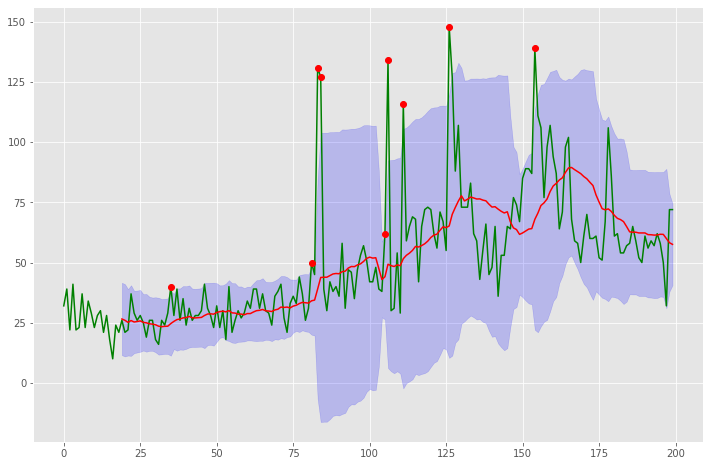

In [19]:
class Detector:
    
    def __init__(self):
        self.history = []
        
    def detect(self, tpl):
        self.history.append(tpl)
        tf = pd.DataFrame(self.history)
        # Your code goes here
        r_win = 20
        v_mean = tf['value'].rolling(r_win).mean()
        v_std = tf['value'].rolling(r_win).std()
        v_upper = v_mean[-1:] + 2*v_std[-1:]
        v_lower = v_mean[-1:] - 2*v_std[-1:]
        if (tpl['value'] > v_upper.iloc[-1]) or (tpl['value'] < v_lower.iloc[-1]):
            tpl['anomaly'] = True
        else:
            tpl['anomaly'] = False
        return tpl

obj = Detector()

of = df.reset_index().apply(obj.detect, axis=1)
of.set_index('timestamp')
af = of[of.anomaly==True]
plt.figure()
plt.plot(of.index, df['value'], color='g')
plt.plot(of.index, v_mean, color='r')
plt.plot(af.index, af['value'], 'o',color='r')
plt.fill_between(of.index, v_mean-2*v_std, v_mean+2*v_std, color='b', alpha=0.2)

We've mastered the shallows 

<img src='../static/dog_cat_passenger.gif' width='600'/>


# Part 4

> Detection using a [Twitter](https://blog.twitter.com/engineering/en_us/a/2015/introducing-practical-and-robust-anomaly-detection-in-a-time-series.html) inspired Seasonal ESD Method

tl;dr:
 - Understand Seasonal Decomposition
 - See how underlying trends impact a signal's statistics   
 - Introduce the Student T test and generalised form ESD 
 - Build an anomaly detector that can handle seasonality
 
( ESD - Generalised Extreme Stundentised Deviate )

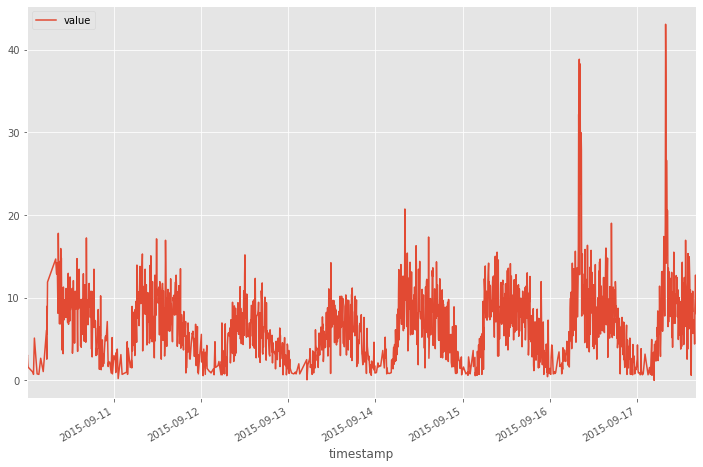

In [20]:
fd = '../data/realTraffic/occupancy_t4013.csv'
df = pd.read_csv(fd, 
    index_col=0, 
    parse_dates=True
)
#df = df['2015-04-10':]
df = df['2015-09-10':]
df.plot()

In [21]:
df.head(5)

value
timestamp                 
2015-09-10 00:03:00   2.61
2015-09-10 00:13:00   3.06
2015-09-10 00:18:00   2.11
2015-09-10 00:23:00   1.61
2015-09-10 01:48:00   0.94

So we have: 
 - A noisy signal
 - Generally records are arriving every 4-10 mins
 - Looks like some records may be getting lost 

> **Question:** How do we fix this? 

 - Resample and 
 - Interpolate if needed 
 
 > **Question:** What would be a frequency and why?

## Probability distribution of raw signal



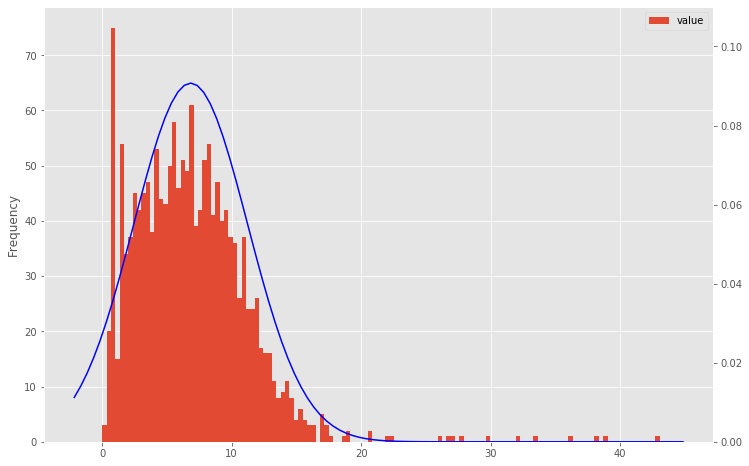

In [22]:
from scipy.stats import norm # Normal distribution

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.grid(False)
df.plot.hist( stacked=True, bins=128, ax=ax1 )

xmin,xmax,ymin,ymax=plt.axis()
x_axis = np.arange(xmin, xmax, 0.5)
ax2.set_ylim(0,0.11)
ax2.plot(x_axis, norm.pdf(x_axis,df.mean(),df.std()),color='blue')

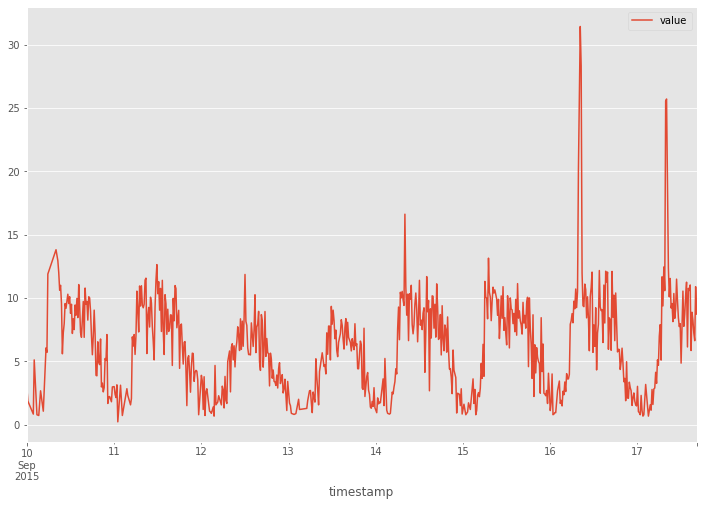

In [23]:
s_rule = '15T' #15 mins
n_sample = 96  #Number of 15mins in 24 hours  
sf = df.resample(s_rule).mean()
sf.interpolate(method='time',inplace=True)
sf.plot()

## Seasonal decomposition

With the now cleaner signal we can split out:
 - Underlying trend, eg increasing over time
 - Seasonal component, repeated patterns
 - residual, i call it noise, it is what is left over


*Note:* I believe twitter uses a polynomial fit to extract the trend, the 'statsmodels' method uses moving averages / convolution. Hence the delay before the trend line starts.

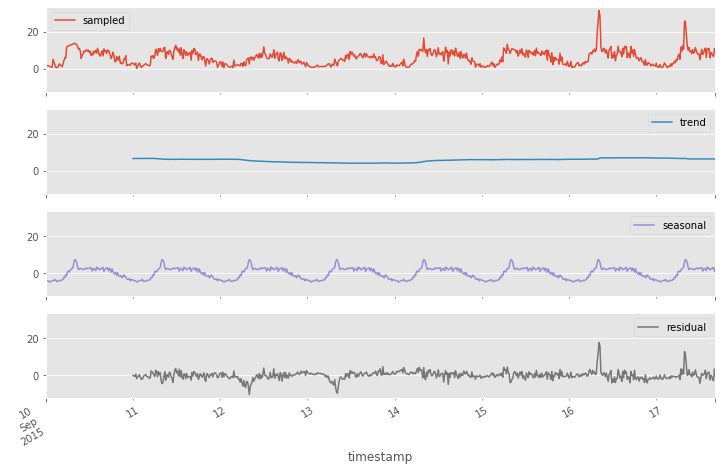

In [24]:
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(sf, two_sided=False, freq=n_sample)
rf = pd.concat([sf, res.trend, res.seasonal, res.resid], axis=1)
rf.columns = ['sampled', 'trend', 'seasonal', 'residual']
fig = rf.plot(subplots=True,sharey=True)  

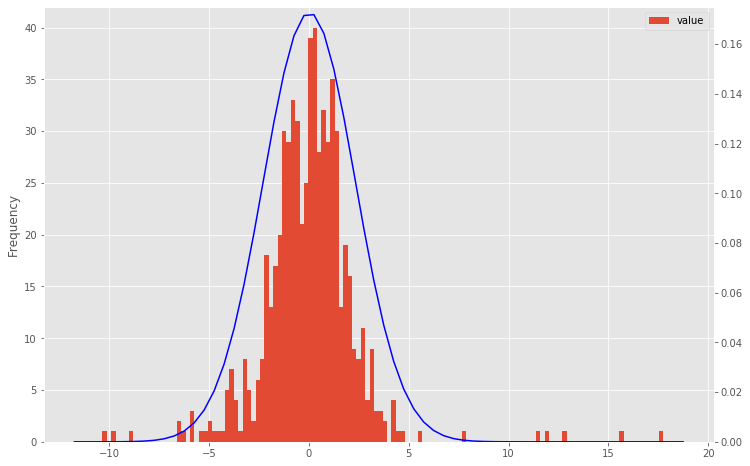

In [25]:
sf = res.resid
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.grid(False)
sf.plot.hist( stacked=True, bins=128, ax=ax1 )

xmin,xmax,ymin,ymax=plt.axis()
x_axis = np.arange(xmin, xmax, 0.5)
ax2.set_ylim(0,.175)
ax2.plot(x_axis, norm.pdf(x_axis,sf.mean(),sf.std()),color='blue')

## Central Limit Theorem

If you have a population with mean and standard deviation and 
take sufficiently large random samples from the population with 
replacement, then the distribution of the sample means will be 
approximately normally distributed.

## Student T test and Generalised ESD

### Student T test
William Sealey Gosset, worked Guinness brewery, under company policy he was prevented from releasing his article under his own name. He instead used the alias `A Student`. 

tl;dr: 
 - The test is used when sample size is small
 - Small sample sizes kind of distort the distribution
 - Can be used to see I a value value if significant 
 
### Generalised ESD

 Is based on the Student T test, but:
  - looks for up to n outliers in a given set 
  

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11f713950>,
      dtype=object)

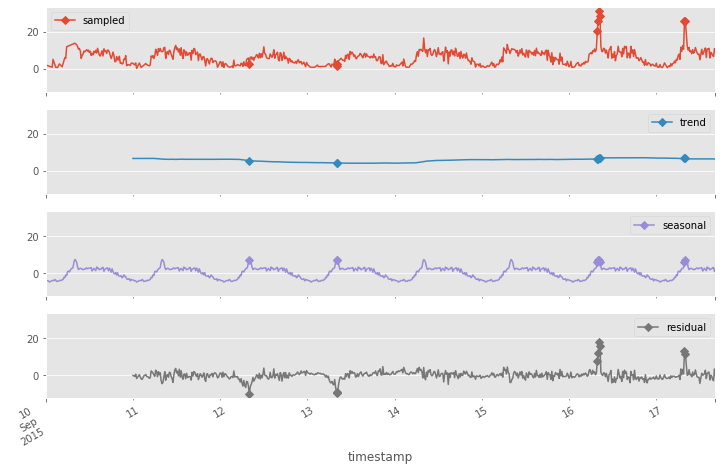

In [26]:
from PyAstronomy import pyasl

arr = rf['residual'][n_sample:]
nos, anomalies = pyasl.generalizedESD(arr, 10, 0.05, fullOutput=False)
mark = [x+n_sample for x in anomalies]
rf.plot( subplots=True, sharey=True, marker='D', markevery=mark )

### **Excercise 4:** Your turn

Todo:
 - Turn this knowledge into an anomaly detector

```python
class Detector:
    
    def __init__(self):
        self.history = []
        
    def detect(self, tpl):
        self.history.append(tpl)
        tf = pd.DataFrame(self.history)
        # Your code goes here
        print(tf)
        return tpl

obj = Detector()

df.reset_index().apply(obj.detect, axis=1)
```
 - If you get time plot results  

Next level 

<img src='../static/dog_dolphin.gif' />

## References

[1] Y. B. Nikolay Laptev Saeed Amizadeh. (Mar. 2015),
A benchmark dataset for time series anomaly
detection, Yahoo, [link](http://yahoolabs.tumblr.com/post/114590420346/abenchmark-dataset-for-time-series-anomaly)


[2] A. Kejariwal. (Jan. 2015), Introducing practical and
robust anomaly detection in a time series, Twitter,
[link](https://blog.twitter.com/engineering/en_us/a/2015/introducing-practical-and-robust-anomaly-detection-in-a-time-series.html)


[3] (2015). Twitter github repository, Twitter, [link](https://github.com/twitter/AnomalyDetection)


[4] J. Hawkins. (Sep. 2011), Hierarchical temporal
memory, [link](https://numenta.com/neuroscience-research/research-publications/papers/hierarchical-temporal-memory-white-paper/)


[5] (2015). The numenta anomaly benchmark, [link](https://github.com/numenta/NAB)


[6] B. Rosner, “Percentage points for a generalized
esd,” Technometrics, vol. 25, no. 2, pp. 165–172,
May 1983